In [3]:
# Direct Python to plot all figures inline (i.e., not in a separate window)
%matplotlib inline

# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Division of two integers in Python 2.7 does not return a floating point result. The default is to round down 
# to the nearest integer. The following piece of code changes the default.
from __future__ import division

In [115]:
# Directory where the csv data file is located
workdir =  '../../data/raw_data/'
data_message = pd.read_csv('../../data/raw_data/AAPL_05222012_0930_1300_message.tar.gz',compression='gzip')
data_lob = pd.read_csv('../../data/raw_data/AAPL_05222012_0930_1300_LOB_2.tar.gz',compression='gzip')

In [116]:
#drop redundant time
col_names=data_lob.columns
delete_list=[i for i in col_names if 'UPDATE_TIME' in i]
for i in delete_list:
    data_lob=data_lob.drop(i,1)

In [117]:
#functions for renaming
def rename(txt):
    txt=txt[16:].split('..')[0]
    index=0
    ask_bid=''
    p_v=''
    if txt[-2].isdigit():
        index=txt[-2:]
    else:
        index=txt[-1]
    if txt[:3]=="BID":
        ask_bid='bid'
    else:
        ask_bid='ask'
    if txt[4:9]=="PRICE":
        p_v='P'
    else:
        p_v='V'
    return('_'.join([p_v,index,ask_bid]))

In [118]:
#rename columns
col_names=data_lob.columns
new_col_names=[]
new_col_names.append('index')
new_col_names.append('Time')
for i in col_names[2:]:
    new_col_names.append(rename(i))
len(new_col_names)
data_lob.columns=new_col_names

In [119]:
#feature: bid-ask spreads and mid price
for i in list(range(1, 11)):
    bid_ask_col_name='_'.join(['spreads',str(i)])
    p_i_ask='_'.join(['P',str(i),'ask'])
    p_i_bid='_'.join(['P',str(i),'bid'])
    data_lob[bid_ask_col_name]=data_lob[p_i_ask]-data_lob[p_i_bid]
    
    mid_price_col_name = '_'.join(['mid_price',str(i)])
    data_lob[mid_price_col_name]=(data_lob[p_i_ask]+data_lob[p_i_bid])/2

In [228]:
data_lob.head()

,index,Time,P_1_bid,V_1_bid,P_1_ask,V_1_ask,P_2_bid,V_2_bid,P_2_ask,V_2_ask,...,spreads_6,mid_price_6,spreads_7,mid_price_7,spreads_8,mid_price_8,spreads_9,mid_price_9,spreads_10,mid_price_10
0,1,2012/05/22 09:30:00.000,569.02,40,570.0,400,568.80,100,570.01,100,...,2.4,569.20,2.80,569.270,3.64,569.170,3.70,569.150,4.08,569.200
1,2,2012/05/22 09:30:00.003,569.02,40,570.0,400,568.80,100,570.01,100,...,2.4,569.20,2.68,569.210,3.32,569.010,3.69,569.145,3.84,569.080
2,3,2012/05/22 09:30:00.003,569.02,40,570.0,400,568.80,100,570.01,100,...,2.4,569.20,2.67,569.205,3.20,568.950,3.37,568.985,3.83,569.075
3,4,2012/05/22 09:30:00.003,569.03,8,570.0,400,569.02,40,570.01,100,...,2.3,569.25,2.54,569.270,2.68,569.210,3.32,569.010,3.69,569.145
4,5,2012/05/22 09:30:00.003,569.03,8,570.0,400,569.02,40,570.01,100,...,2.3,569.25,2.52,569.260,2.67,569.205,3.20,568.950,3.37,568.985


# Analyze $\Delta t$ and generate good graphs!

In [184]:
#compute frequency of midprice stationary
diff=data_lob['mid_price_1']
bid = data_lob['P_1_bid']
ask = data_lob['P_1_ask']

# print('t', 'up', 'stationary','down', 'up', 'stationary','down')

upper_step = 100
for t in list(range(1, upper_step, 5)):
    print(t)
    # label from mid-price
    delta_midprice = np.array(diff[t:]) - np.array(diff[:(-1*t)])
    dummy_up = delta_midprice > 0
    dummy_down = delta_midprice < 0
    dummy_stationary = delta_midprice == 0
    freq_stationary = sum(dummy_stationary) / len(dummy_stationary)
    freq_up   = sum(dummy_up) / len(dummy_up)
    freq_down = sum(dummy_down) / len(dummy_down)
    
    if t == 1:
        delta_t = np.array([t,])
        up_MP = np.array([freq_up,])
        stationary_MP = np.array([freq_stationary,])
        down_MP = np.array([freq_down,])
    else:
        delta_t = np.append(delta_t, t)
        up_MP = np.append(up_MP, freq_up)
        stationary_MP = np.append(stationary_MP, freq_stationary)
        down_MP = np.append(down_MP, freq_down)

df_MP = pd.DataFrame({'delta_t' : delta_t,
                              '1' : up_MP  ,
                              '0' : stationary_MP ,
                              '-1': down_MP})


upper_step_sc = 2000
for t in range(1, upper_step_sc, 100):
    print(t)
    # label from spread crossing
    up            = np.array(bid[t:]) - np.array(ask[:(-1*t)]) > 0
    down          = np.array(ask[t:]) - np.array(bid[:(-1*t)]) < 0
    stationary    = np.logical_not(np.logical_or(up, down))
    freq_stationary_crossing = sum(stationary) / len(stationary)
    freq_up_crossing = sum(up) / len(up)
    freq_down_crossing = sum(down) / len(down)

    if t == 1:
        delta_t = np.array([t,])
        up_SC = np.array([freq_up_crossing,])
        stationary_SC = np.array([freq_stationary_crossing,])
        down_SC = np.array([freq_down_crossing,])
    else:
        delta_t = np.append(delta_t, t)
        up_SC = np.append(up_SC, freq_up_crossing)
        stationary_SC = np.append(stationary_SC, freq_stationary_crossing)
        down_SC = np.append(down_SC, freq_down_crossing)

df_SC = pd.DataFrame({'delta_t' : delta_t,
                              '1' : up_SC  ,
                              '0' : stationary_SC ,
                              '-1': down_SC})

1
6
11
16
21
26
31
36
41
46
51
56
61
66
71
76
81
86
91
96
1
101
201
301
401
501
601
701
801
901
1001
1101
1201
1301
1401
1501
1601
1701
1801
1901


In [188]:
print(df_MP)
print(df_SC)

          -1         0         1  delta_t
0   0.085643  0.829787  0.084570        1
1   0.259719  0.497485  0.242795        6
2   0.344446  0.335358  0.320196       11
3   0.394626  0.241642  0.363732       16
4   0.429767  0.176322  0.393910       21
5   0.451250  0.135645  0.413105       26
6   0.466886  0.105792  0.427321       31
7   0.477896  0.084951  0.437152       36
8   0.486294  0.068676  0.445029       41
9   0.490165  0.058564  0.451271       46
10  0.494327  0.049783  0.455890       51
11  0.496559  0.044123  0.459318       56
12  0.499387  0.037765  0.462849       61
13  0.500846  0.034154  0.464999       66
14  0.502598  0.029919  0.467484       71
15  0.503516  0.027625  0.468859       76
16  0.504360  0.025827  0.469813       81
17  0.505426  0.024421  0.470154       86
18  0.506317  0.022274  0.471409       91
19  0.505949  0.021890  0.472161       96
          -1         0         1  delta_t
0   0.000000  1.000000  0.000000        1
1   0.056117  0.886828  0.057055  

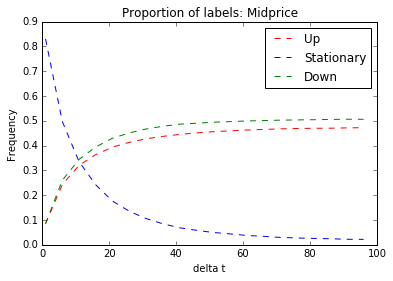

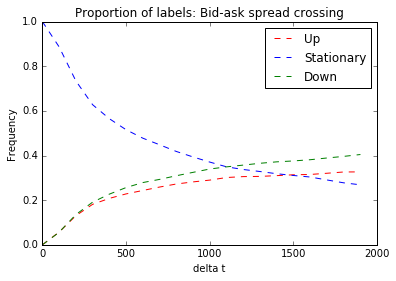

In [231]:
fig_MP = plt.figure()
plt.plot(df_MP['delta_t'], df_MP['1'], 'r--', 
         df_MP['delta_t'], df_MP['0'], 'b--',
         df_MP['delta_t'], df_MP['-1'], 'g--')
plt.legend(['Up', 'Stationary', 'Down'])
plt.xlabel('delta t')
plt.ylabel('Frequency')
plt.title('Proportion of labels: Midprice')

plt.show()

fig_SC = plt.figure()
plt.plot(df_SC['delta_t'], df_SC['1'], 'r--', 
         df_SC['delta_t'], df_SC['0'], 'b--',
         df_SC['delta_t'], df_SC['-1'], 'g--')
plt.legend(['Up', 'Stationary', 'Down'])
plt.xlabel('delta t')
plt.ylabel('Frequency')
plt.title('Proportion of labels: Bid-ask spread crossing')
plt.show()

fig_MP.savefig('../report/delta_t_MP.png')
fig_SC.savefig('../report/delta_t_SC.png')

# A test for profit calculator

In [21]:
##### Old version #####

def profit_calculator(data, delta_t = 30, simple = True):
    """Calculate the profit of trading strategy based on precisely the prediction of the model
        Parameters
        ----------
        data    : a data frame with "predicted" "P_1_bid" "P_1_ask"
        delta_t : time gap between 
        simple  : a dummy, True, means we make transection decisions only every delta_t period. False, means we track the current 
                  hand every period, only if we don't have anything at hand, we make transactions

        Returns
        -------
        profit        : a numeric, the net profit at the end
        profit_series : a np.array, time series tracking net profit at each point of time
        
        """    
    if simple == True:
        data_effective = data.loc[np.arange(len(data)) % delta_t == 0]
        bid = data_effective['P_1_bid']
        ask = data_effective['P_1_ask']
        trade_decision = data_effective['predicted'][:-1]
        buy_profit = np.array(bid[1:]) - np.array(ask[:-1])
        profit = sum(trade_decision * buy_profit)
        return profit
    else:
        
#         print(data_effective)
#         print(data['P_1_bid'])
#         print(data['P_1_ask'])
        
#         print(data['P_1_bid'][delta_t:])
#         print(data['P_1_ask'][:(-1 * delta_t)])
        
#         print(np.array(data['P_1_bid'][delta_t:]))
#         print(np.array(data['P_1_ask'][:(-1 * delta_t)]))
        
        buy_profit = np.array(data['P_1_bid'][delta_t:]) - np.array(data['P_1_ask'][:(-1 * delta_t)])
        trade_decision_draft = data['predicted'][:(-1 * delta_t)]
        T = len(buy_profit)
        
        #print(T)
        #print(buy_profit)
        #print(trade_decision_draft)
        
        current_state = [0] * T
        trade_decision = [0] * T
        #print(current_state[T])
        for i in range(T):
            if current_state[i] == 1:
                trade_decision[i] = 0
            else:
                trade_decision[i] = trade_decision_draft[i]
                if i < T-1:
                    #print(i)
                    current_state[i+1] = int(sum(trade_decision[max(0, i - delta_t):i]) != 0)
        profit = sum(trade_decision * buy_profit)
        return profit

In [29]:
d = {'P_1_bid' : pd.Series([1., 2., 3., 5., 1., 2., 3., 5.]),
     'P_1_ask' : pd.Series([1., 2., 3., 4., 1., 2., 3., 4.]),
     'predicted' : pd.Series([0, 1, -1, 1, 1, 1, -1, 1])} 
df = pd.DataFrame(d)
print(df)

   P_1_ask  P_1_bid  predicted
0      1.0      1.0          0
1      2.0      2.0          1
2      3.0      3.0         -1
3      4.0      5.0          1
4      1.0      1.0          1
5      2.0      2.0          1
6      3.0      3.0         -1
7      4.0      5.0          1


In [75]:
print(profit_calculator(df, delta_t = 1, simple = True))
print(profit_calculator(df, delta_t = 3, simple = False))

-2.0
[0, 0, 0, 0, 0] [0, 0, 0, 0, 0] 0 [] 0
[0, 0, 1, 0, 0] [0, 1, 0, 0, 0] 1 [0] 0
[0, 0, 1, 1, 0] [0, 1, 0, 0, 0] 2 [0 1] 1
[0, 0, 1, 1, 1] [0, 1, 0, 0, 0] 3 [1 0] 1
[0, 0, 1, 1, 1] [0, 1, 0, 0, 0] 4 [0 0] 0
-1.0


In [29]:
df.iloc[:-1,:]

,P_1_ask,P_1_bid,predicted
a,1.0,1.0,0
b,2.0,2.0,1
c,3.0,3.0,-1


In [73]:
##### New version #####

def profit_calculator(data, delta_t = 30, simple = False):
    """Calculate the profit of trading strategy based on precisely the prediction of the model
        Parameters
        ----------
        data    : a data frame with "predicted" "P_1_bid" "P_1_ask"
        delta_t : time gap between 
        simple  : a dummy, True, means we make transection decisions only every delta_t period. False, means we track the current 
                  hand every period, only if we don't have anything at hand, we make new transactions

        Returns
        -------
        profit        : a numeric, the net profit at the end
        
        """    
    if simple == True:
        data_effective = data.loc[np.arange(len(data)) % delta_t == 0]
        bid            = data_effective['P_1_bid']
        ask            = data_effective['P_1_ask']
        trade_decision = data_effective['predicted'][:-1]
        buy_profit     = np.array(bid[1:]) - np.array(ask[:-1])
        sell_profit    = np.array(bid[:-1]) - np.array(ask[1:])
        profit         = sum((np.array(trade_decision) > 0) * buy_profit + (np.array(trade_decision) < 0) * sell_profit)
        return profit
    else:
        buy_profit           = np.array(data['P_1_bid'][delta_t:]) - np.array(data['P_1_ask'][:(-1 * delta_t)])
        sell_profit           = np.array(data['P_1_bid'][:(-1 * delta_t)]) - np.array(data['P_1_ask'][delta_t:])
        trade_decision_draft = data['predicted'][:(-1 * delta_t)]
        T                    = len(buy_profit)
        current_state        = [0] * T
        trade_decision       = [0] * T
        profit               = 0
        for i in range(T):
            if current_state[i] == 1:
                trade_decision[i] = 0
            else:
                trade_decision[i] = trade_decision_draft[i]
                    
            if i < T-1:
                current_state[i+1] = int(sum(abs(np.array(trade_decision[max(0, i + 1 - delta_t):i + 1]))) != 0)
        profit = sum((np.array(trade_decision) > 0) * buy_profit + (np.array(trade_decision) < 0) * sell_profit)
        return profit     

In [67]:
abs(np.array([1, 2, -2, -3]))[1]

2

In [56]:
1 == True

True